# Stochastic Grid 2
#### Fast Numerical Integration
Aaron Smith 2025.  
Based on the full **Stochastic 3** simulation, excpet this one actually does numerical integration, rather than drawing millions of samples!

## Import Statements and Colours

In [1]:
## Import Statements
import math
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import matplotlib.cm as mplcm
import itertools as itl
import sys
import copy
from numba import jit

## Colours
green = "#6dc317"
yellow = "#e8c636"
orange = "#ed7d31"
red = "#d93a15"
purple = "#8c43ed"
blue = "#177add"
black = "#000000"
charcoal = "#2f2f2f"
grey = "#c2c2c2"
white = "#ffffff"
off_white = "#fafafa"
transparent = [1.0, 1.0, 1.0, 0]

# Colourmaps
spectral = mplcm.Spectral
turbo = mplcm.turbo
cvidis = mplcm.cividis
viridis = mplcm.viridis
magma = mplcm.magma
cool = mplcm.cool
ygb = mplcm.YlGnBu

## Function Library (PDFs)

#### Normal / Gaussian Distribution

$$P_N(x) = \frac{1}{\sqrt{2\sigma^2\pi}}e^{\frac{-(x-\mu)^2}{2\sigma^2}}$$

In [2]:
def Normal(x, mean = 0, std = 1, alpha = None):
    return(sp.stats.norm.pdf(x, loc = mean, scale = std))

#### Skew Normal Distribution

Generalisation of the Normal Distribution to allow non-zero skew.  
PDF given by

$$P(x, \mu, \sigma, a) = \frac{2}{\sigma}p_N\bigl(\frac{x - \mu}{\sigma}\bigr) \times c_N\bigl(a\frac{x - \mu}{\sigma}\bigr)$$

in which: $p_N$ is the Normal Distribution PDF for variable $x$, (or $\frac{x - \mu}{\sigma}$), and $c_N$ is the Normal Distribution CDF.  
Note that $a$, which can range from $-\infty$ to $+\infty$ is *not* the Skew, which ranges -1 to 1.  


This is made worse by the fact that the true sample mean and std do not match the nominal mean and std. If true mean is $M$ and true std is $\Sigma$, and we define $\delta = \frac{\alpha}{\sqrt{1 + \alpha^2}}$then:

$$M = \mu + \sigma\delta\sqrt{\frac{2}{\pi}}$$

$$\Sigma^2 = \sigma^2 \bigl( 1 - \frac{2\delta^2}{\pi} \bigr)$$

Inverting these to generate $\mu$, $\sigma$ from supplied true mean and std:

$$\sigma^2 = \Sigma^2 \bigl( 1 - \frac{2\delta^2}{\pi} \bigr)^{-1}$$

$$\mu = M - \sigma\delta\sqrt{\frac{2}{\pi}}$$

In [3]:
def Skew_Normal(x, mean = 0, std = 1, alpha = 0):

    delta = alpha / (1 + alpha**2)**(0.5)
    sigma = (std**2 * (1 - (2*delta**2)/(np.pi))**(-1))**(0.5)
    mu = mean - sigma*delta*(2/np.pi)**(0.5)
    
    return(sp.stats.skewnorm.pdf(x, loc = mu, scale = sigma, a = alpha))

#### Weibull

We call the Weibull using ```scale``` $\lambda$ and ```shape``` $k$ or $c$ directly.

Wikipedia gives Weibull as:

$$p(x,k,\lambda) = \frac{k}{\lambda}\frac{x^{k-1}}{\lambda}e^{-(x/\lambda)^k}$$
for $$x, k, \lambda > 0$$

Empirically, $$k \approx 1/CV = \frac{\overline{x}}{\Delta x}$$
So, $$\lambda \approx \frac{\overline{x}}{\Gamma(1 + 1/k)}$$

In [4]:
def Weibull(x, scale = 1, shape = 1, alpha = None):
    return(sp.stats.weibull_min.pdf(x, c = shape, scale = scale))

#### Erlang Distribution
The Erlang distribution arises from multiple coupled exponential processes.
$$p(x,k,\lambda) = \frac{\lambda^k x^{k-1}e^{-\lambda x}}{(k-1)!}$$

For shape $k$ and rate $\lambda$. It has mean $k/\lambda$ and std $\sqrt{k}/\lambda$.

Therefore:
$$\lambda = \frac{\overline{x}}{\Delta x^2}$$
$$k = \frac{\overline{x}^2}{\Delta x^2} = \lambda\overline{x}$$

Scipy uses the parameters ```a``` and ```scale```. ```a``` is equivalent to $k$ and ```scale``` is equivalent to $1/\lambda$.

For our purposes, we will use mean and shape, noting that mean = shape * scale.

In [5]:
def Erlang(x, mean, shape, alpha = None):
    scale = mean/shape
    return(sp.stats.erlang.pdf(x, scale = scale, a = shape))

#### Check PDFs

In [23]:
## check with params
mean = 17
std = 2.5
alpha = 10
scale = 17
shape = 2

## intermediate params for skew normal
delta = alpha / (1 + alpha**2)**(0.5)
sigma = (std**2 * (1 - (2*delta**2)/(np.pi))**(-1))**(0.5)
mu = mean - sigma*delta*(2/np.pi)**(0.5)

print("Distribution.|Integral (should == 1).                    |Mean.             |Var.             |Skew.           |")
print("Normal     ", sp.integrate.quad(Normal, 0.01, 100, args = (mean, std)), sp.stats.norm.stats(loc = mean, scale = std, moments = "mvs"))
print("Skew Normal", sp.integrate.quad(Skew_Normal, 0.01, 100, args = (mean, std, alpha)), sp.stats.skewnorm.stats(loc = mu, scale = sigma, a = alpha, moments = "mvs"))
print("Weibull    ", sp.integrate.quad(Weibull, 0.01, 100, args = (scale, shape)), sp.stats.weibull_min.stats(scale = scale, c = shape, moments = "mvs"))
print("Erlang     ", sp.integrate.quad(Erlang, 0.01, 100, args = (mean, shape)), sp.stats.erlang.stats(scale = mean/shape, a = shape, moments = "mvs"))

Distribution.|Integral (should == 1).                    |Mean.             |Var.             |Skew.           |
Normal      (0.9999999999946223, 6.65306814606188e-09) (np.float64(17.0), np.float64(6.25), np.float64(0.0))
Skew Normal (1.0000000000000004, 1.7758549400849381e-09) (np.float64(17.0), np.float64(6.249999999999998), np.float64(0.9555570924911115))
Weibull     (0.9999996539792977, 5.543281389862133e-11) (np.float64(15.065857732696886), np.float64(62.01993077813748), np.float64(0.6311106578189344))
Erlang      (0.9999000737083718, 9.139249687668541e-11) (np.float64(17.0), np.float64(144.5), np.float64(1.414213562373095))


#### Plot PDFs

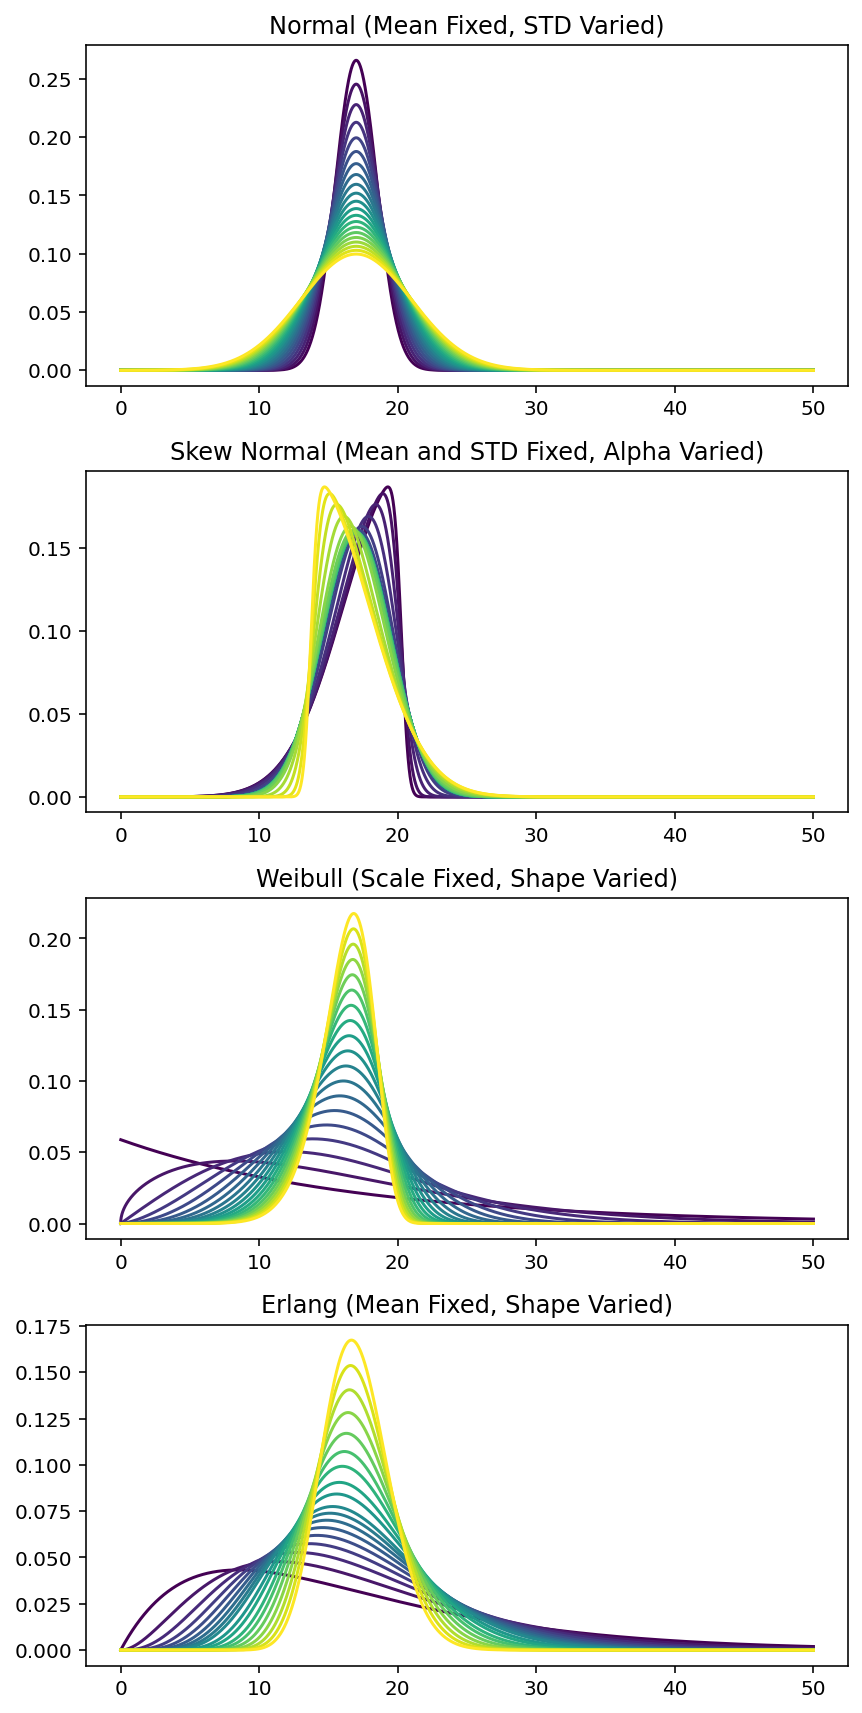

In [7]:
fig, axs = plt.subplots(4, 1, figsize = (6, 12), dpi = 144)
cmap = viridis
t = np.linspace(0.01, 50, 5000)

## Plot Normal dist for different stds
stds = np.linspace(1.5, 4, 21)
for i in range(len(stds)):
    axs[0].plot(t, Normal(t, mean, stds[i]), color = cmap(i/(len(stds) - 1)))
axs[0].set_title("Normal (Mean Fixed, STD Varied)")

## Plot Skew Normal dist for different alphas
alphas = np.array([-10, -6.5, -4, -2.5, -1.5, -1, -0.65, -0.4, -0.25, -0.15, -0.1, 0, 0.1, 0.15, 0.25, 0.4, 0.65, 1, 1.5, 2.5, 4, 6.5, 10])
for i in range(len(alphas)):
    axs[1].plot(t, Skew_Normal(t, mean, std, alphas[i]), color = cmap(i/(len(alphas) - 1)))
axs[1].set_title("Skew Normal (Mean and STD Fixed, Alpha Varied)")

## Plot Weibull dist for different shapes
shapes = np.linspace(1, 10, 19)
for i in range(len(shapes)):
    axs[2].plot(t, Weibull(t, scale, shapes[i]), color = cmap(i/(len(shapes) - 1)))
axs[2].set_title("Weibull (Scale Fixed, Shape Varied)")

## Plot Erlang dist for different shapes
shapes = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 20, 24, 29, 35, 42, 50])
for i in range(len(shapes)):
    axs[3].plot(t, Erlang(t, mean, shapes[i]), color = cmap(i/(len(shapes) - 1)))
axs[3].set_title("Erlang (Mean Fixed, Shape Varied)")

fig.tight_layout()

## Define Burst Functions

In [8]:
def beta_N(t, b_mean = 150, m = 20, e = 9.5, m_eff = 8.82):
    return(b_mean)

def beta_L(t, b_mean = 150, m = 20, e = 9.5, m_eff = 8.82):
    return(t * m_eff)

def beta_C(t, b_mean = 150, m = 20, e = 9.5, m_eff = 8.82):
    return(np.clip((t - e) * m, a_min = 0, a_max = None))

## Define k Integral

In [9]:
def robust_log(x):
    if x > 1:
        return(np.log(x))
    else:
        return(0)

In [10]:
def robust_log_array(A):
    A = np.array(A, dtype = "float64")
    
    if len(A.shape) == 1:
        for i in range(A.shape[0]):
            A[i] = robust_log(A[i])
        return(A)

    elif len(A.shape) == 2:
        for i,j in itl.product(range(A.shape[0]) , range(A.shape[1])):
            A[i,j] = robust_log(A[i,j])
        return(A)

    else:
        panic

In [11]:
def Growth_Rate(distribution, burst_function, mean = None, std = None, alpha = None, scale = None, shape = None, LB = 0.01, UB = 100):

    ## intermediate params for skew normal ##
    if distribution == Skew_Normal:
        delta = alpha / (1 + alpha**2)**(0.5)
        sigma = (std**2 * (1 - (2*delta**2)/(np.pi))**(-1))**(0.5)
        mu = mean - sigma*delta*(2/np.pi)**(0.5)

    ## integrate p(x) ln(beta) / x ##
    def function_to_integrate(x):
        if distribution == Normal:
            return Normal(x, mean, std) * robust_log(burst_function(x)) / x
        elif distribution == Skew_Normal:
            return Skew_Normal(x, mean, std, alpha) * robust_log(burst_function(x)) / x
        elif distribution == Weibull:
            return Weibull(x, scale, shape) * robust_log(burst_function(x)) / x
        elif distribution == Erlang:
            return Erlang(x, mean, shape) * robust_log(burst_function(x)) / x
        else:
            raise Exception("Unidentified distribution!")

    k, error = sp.integrate.quad(function_to_integrate, LB, UB)

    
    ## distribution statistics ##
    if distribution == Normal:
        stats = sp.stats.norm.stats(loc = mean, scale = std, moments = "mvs")
    elif distribution == Skew_Normal:
        stats =  sp.stats.skewnorm.stats(loc = mu, scale = sigma, a = alpha, moments = "mvs")
    elif distribution == Weibull:
        stats = sp.stats.weibull_min.stats(scale = scale, c = shape, moments = "mvs")
    elif distribution == Erlang:
        stats = sp.stats.erlang.stats(scale = mean/shape, a = shape, moments = "mvs")

    return(k, stats[0], stats[1]**0.5, stats[2])   # 0: k, 1: mean, 2: std, 3: skew



## Single Axis Competition Experiment (e.g. mean vs mean)

This is a silly little section that I wrote quickly to make mean vs mean heatmaps. It's a bit clunky to read through but it works!

In [90]:
axis = np.linspace(10, 30, 41)
GRs = np.zeros(len(axis))
label_1 = "Mutant Mean Lysis Time (min)"
label_2 = "Wild Type Mean Lysis Time (min)"

In [101]:
name = "Choua_20_15"
distribution = Normal
model = beta_C
std = 0.01
alpha = None
scale = None
shape = None

In [102]:
## set m, e etc here ##
m = 20
e = 15
m_eff = (17-e)*m/(17)

def variable_burst_function(t, b_mean = 150, m = m, e = e, m_eff = m_eff):
    if model is beta_N:
        return(b_mean)
    elif model is beta_L:
        return(t * m_eff)
    elif model is beta_C:
        return(np.clip((t - e) * m, a_min = 0, a_max = None))
    else:
        panic

In [103]:
for i, val in enumerate(axis):
    GRs[i] = Growth_Rate(distribution, variable_burst_function, mean = val, std = std, alpha = alpha, scale = scale, shape = shape,
                         LB = min(0, val - 5*std), UB = val + 5*std)[0]

# print(axis)
# print(GRs)

In [104]:
grid = np.zeros((len(axis),len(axis)))
for i in range(len(axis)):
    grid[i,:] -= GRs
    grid[:,i] += GRs



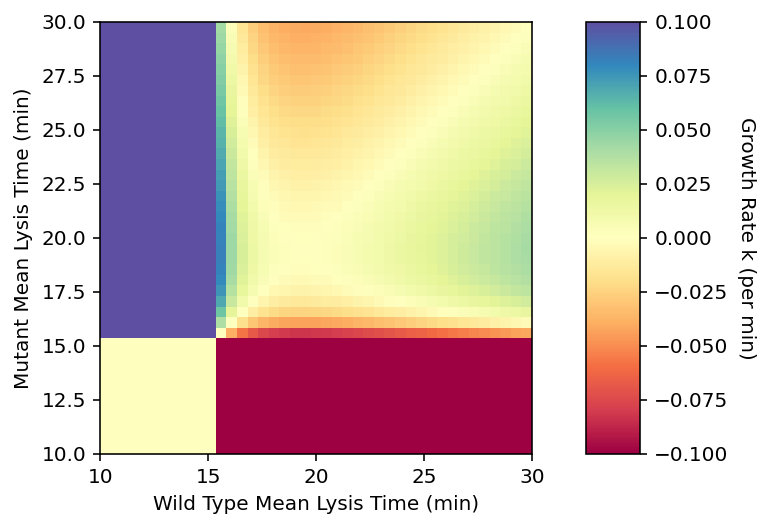

In [105]:
X, Y = 7, 6
scaling = 0.75
fig = plt.figure(figsize=(X*scaling,Y*scaling), dpi = 144)

vmax = 0.1

ax_3 = fig.add_axes([1/X, 1/Y, 4/X, 4/Y])     # right top box - normal heatmap
cax_3 = fig.add_axes([5.5/X, 1/Y, 0.5/X, 4/Y])

im_3 = ax_3.imshow(grid, cmap = spectral, origin = "lower", interpolation = "none",
                   aspect = 1, # force square
                   norm = "linear", extent = [min(axis), max(axis), min(axis), max(axis)], vmin = -vmax, vmax = vmax)
ax_3.set_xlabel(label_2)
ax_3.set_ylabel(label_1)
cbar_3 = fig.colorbar(im_3, cax = cax_3)
cbar_3.outline.set_visible(True)
cbar_3.ax.set_ylabel("Growth Rate k (per min)", rotation=-90, va="bottom")

plt.savefig("MvM_" + name + ".png", bbox_inches = "tight")

# Generate Data and Plots!

## Set Params

In [12]:
## Single Values ##
mean = 17
scale = 17
std = 2.5
alpha = 0
shape = 2
LB = 1
UB = 100

## Arrays ##
means = np.linspace(9, 30, 42)
scales = np.linspace(9, 30, 42)
stds = np.linspace(0.5, 4.5, 41)
alphas = np.array([-10, -6.5, -4, -2.5, -1.5, -1, -0.65, -0.4, -0.25, -0.15, -0.1, 0, 0.1, 0.15, 0.25, 0.4, 0.65, 1, 1.5, 2.5, 4, 6.5, 10])
shapes_W = np.linspace(1, 10, 19)
shapes_E = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 20, 24, 29, 35, 42, 50])

In [13]:
## Distribution ##
distribution = Normal

In [14]:
axis_1 = means
axis_2 = stds
label_1 = "Mean Lysis Time (min)"
label_2 = "Lysis Time STD (min)"

## Run

We're going to create ks, which has shape i.j.m, where m = 3 (for normal, linear, choua).  
At the same time we can generate true_means, true_stds and true_skews, in the same pattern.

In [15]:
I = len(axis_1)
J = len(axis_2)
models = [beta_N, beta_L, beta_C]
M = len(models)
ks = np.zeros((I,J,M))
true_means = np.zeros((I,J,M))
true_stds = np.zeros((I,J,M))
true_skews = np.zeros((I,J,M))
                                                                        #### CHECK THIS WHEN CHANGING DISTRIBUTION ####
for i,j,m in itl.product(range(I),range(J),range(M)):
    ks[i,j,m], true_means[i,j,m], true_stds[i,j,m], true_skews[i,j,m] = Growth_Rate(distribution,
                                                                        models[m],
                                                                        mean = means[i],
                                                                        std = stds[j],
                                                                        alpha = alpha,
                                                                        scale = scale,
                                                                        shape = shape,
                                                                        LB = LB,
                                                                        UB = UB)
    print(i, j, "/", I, J, "            ", end = "\r")

if ks[0,0,0] == ks [3,0,0] or ks[0,0,0] == ks [0,3,0]:
    raise Exception("Aaron I don't think you set the right variables again.")

41 40 / 42 41             

## Compare Mean or Scale Against "Noise" (STD, Skew or Shape)

#### Plot, Using the Axes of Variation Only

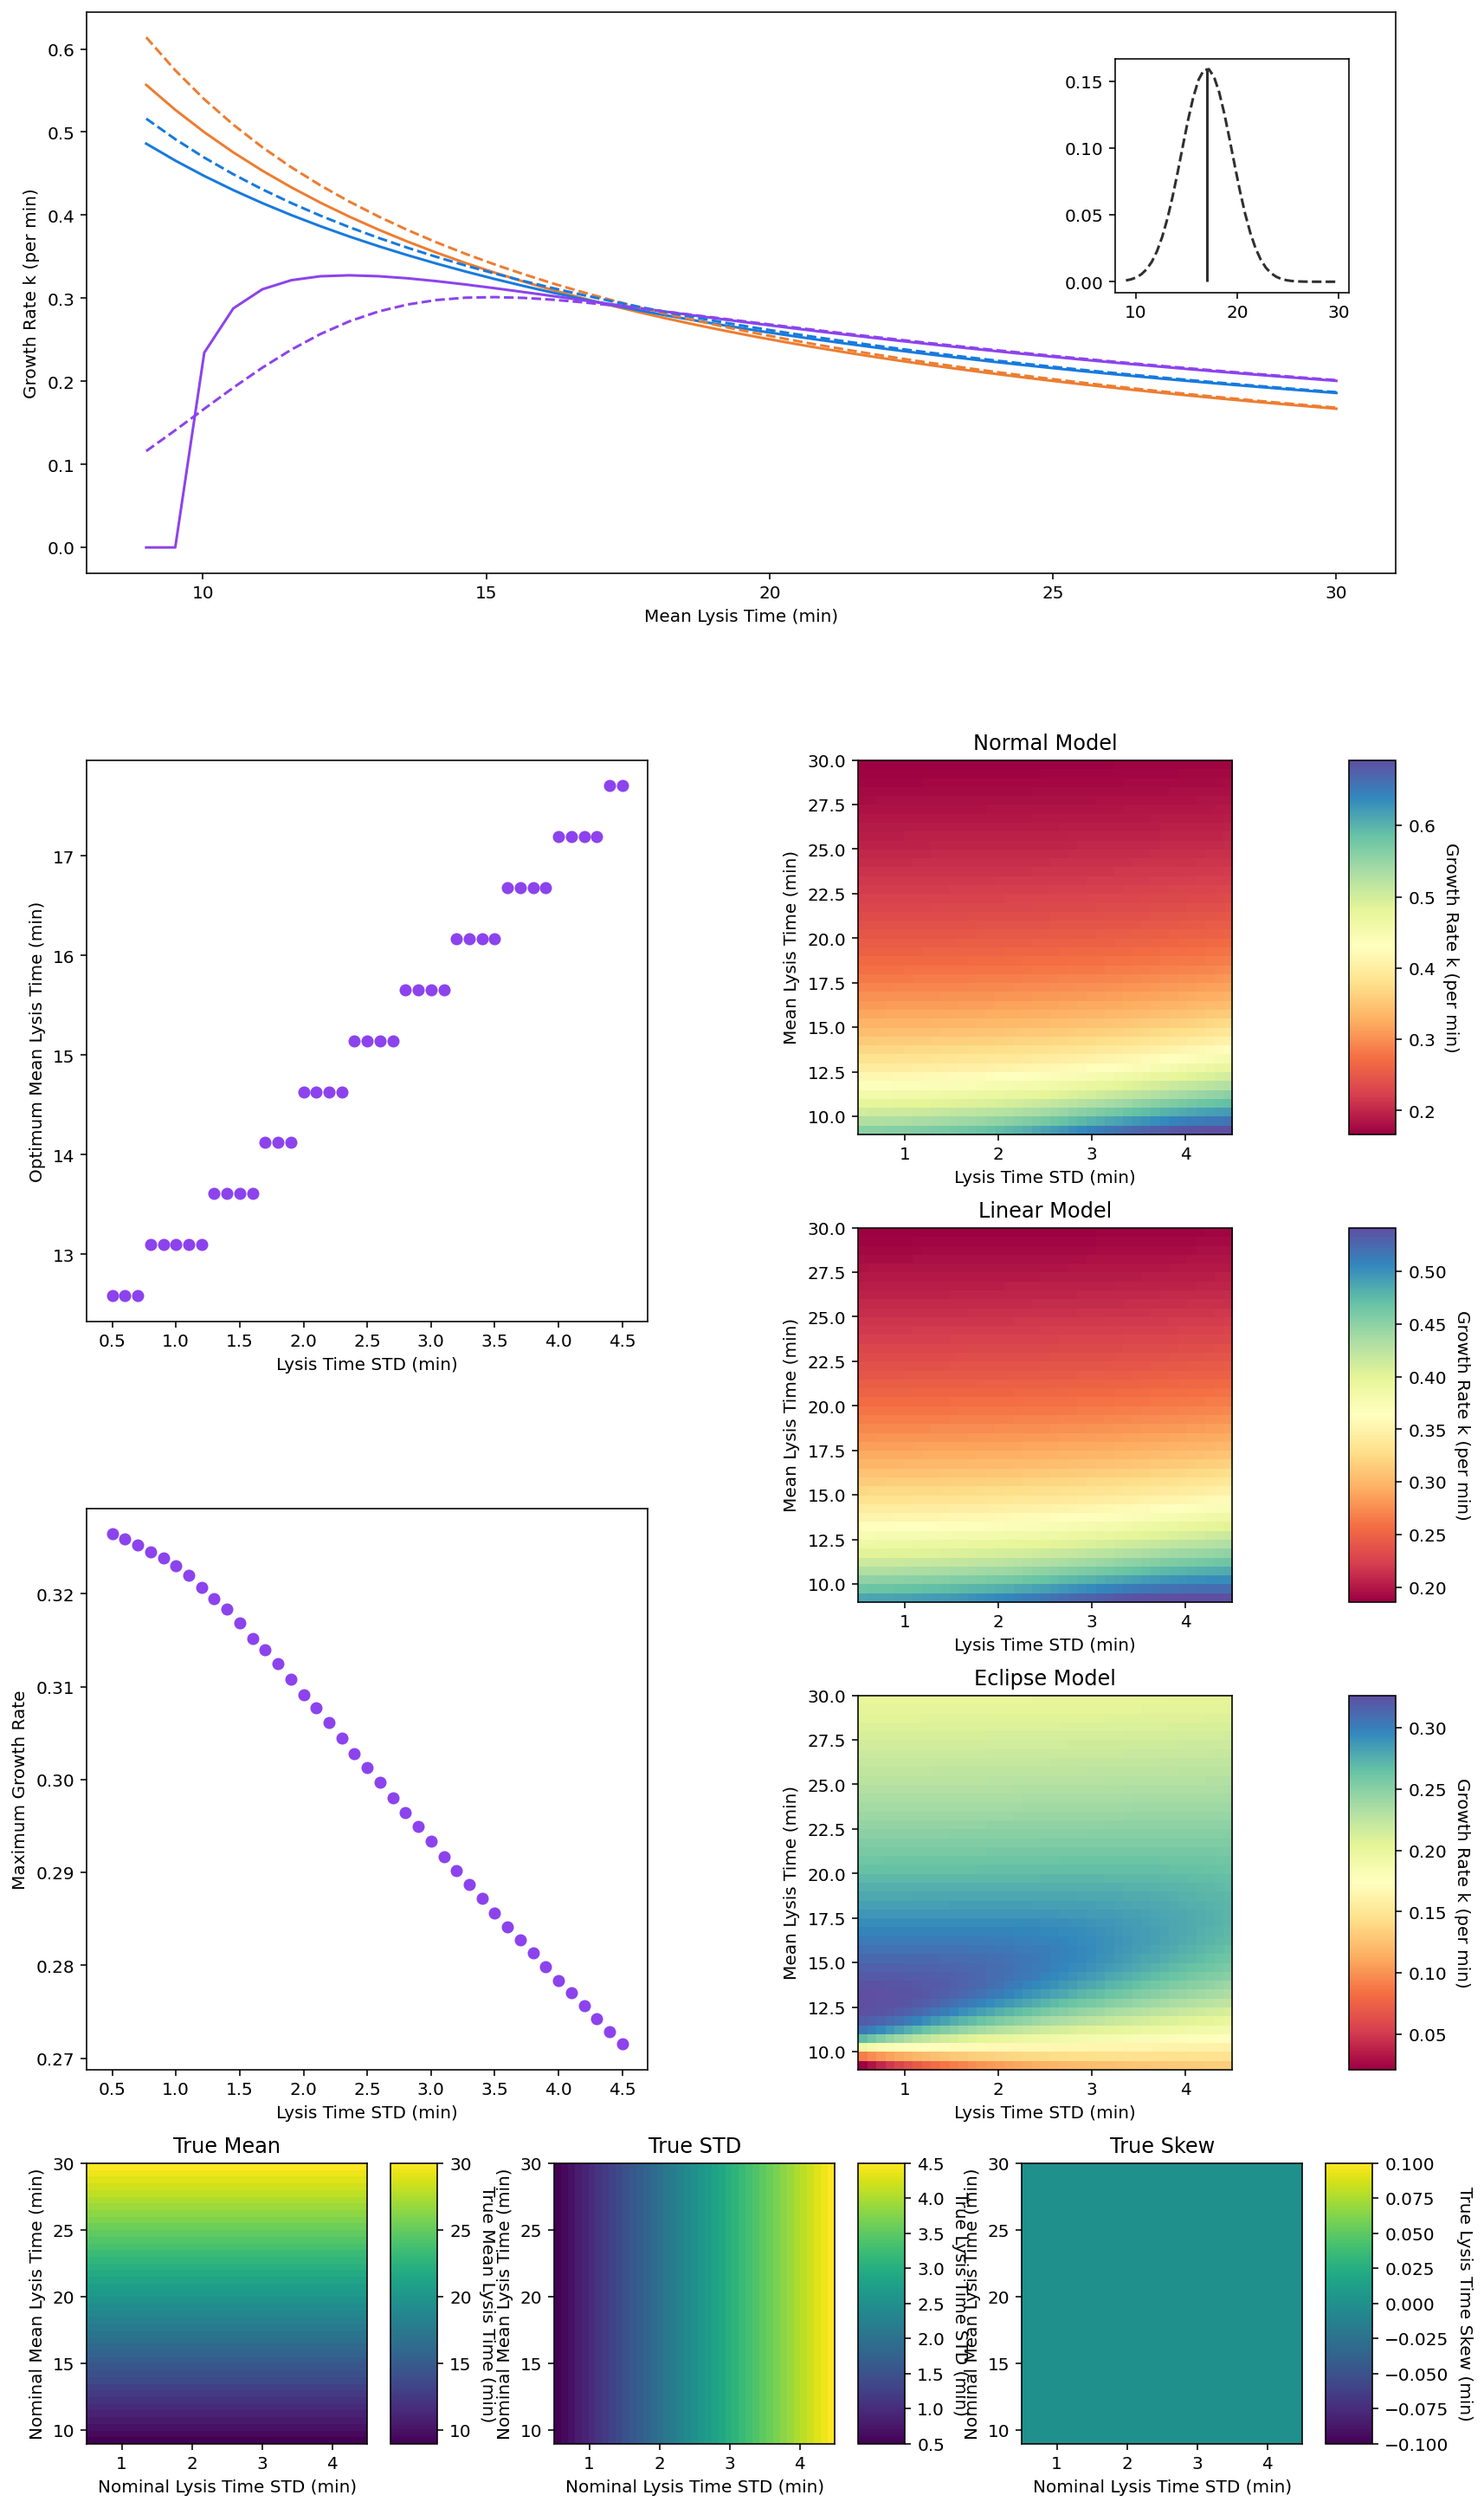

<Figure size 640x480 with 0 Axes>

In [20]:
if axis_1 is means or axis_1 is scales:

    ## Initialise Figure ##
    X, Y = 16, 27
    scaling = 0.75
    fig = plt.figure(figsize=(X*scaling,Y*scaling), dpi = 144)
    
    ax_0 = fig.add_axes([1/X, 21/Y, 14/X, 6/Y])    # large top box - k curves
    ax_1 = fig.add_axes([1/X, 13/Y, 6/X, 6/Y])     # left top box - optimum lysis time
    ax_2 = fig.add_axes([1/X, 5/Y, 6/X, 6/Y])     # left bottom box - growth rate at optimum lysis time
    ax_3 = fig.add_axes([9.25/X, 15/Y, 4/X, 4/Y])     # right top box - normal heatmap
    ax_4 = fig.add_axes([9.25/X, 10/Y, 4/X, 4/Y])     # right middle box - linear heatmap
    ax_5 = fig.add_axes([9.25/X, 5/Y, 4/X, 4/Y])     # right bottom box - eclipse heatmap
    ax_6 = fig.add_axes([12/X, 24/Y, 2.5/X, 2.5/Y])    # inset box - "noisy" distribution
    
    cax_3 = fig.add_axes([14.5/X, 15/Y, 0.5/X, 4/Y])
    cax_4 = fig.add_axes([14.5/X, 10/Y, 0.5/X, 4/Y])
    cax_5 = fig.add_axes([14.5/X, 5/Y, 0.5/X, 4/Y])
    
    ax_7 = fig.add_axes([1/X, 1/Y, 3/X, 3/Y])
    ax_8 = fig.add_axes([6/X, 1/Y, 3/X, 3/Y])
    ax_9 = fig.add_axes([11/X, 1/Y, 3/X, 3/Y])
    
    cax_7 = fig.add_axes([4.25/X, 1/Y, 0.5/X, 3/Y])
    cax_8 = fig.add_axes([9.25/X, 1/Y, 0.5/X, 3/Y])
    cax_9 = fig.add_axes([14.25/X, 1/Y, 0.5/X, 3/Y])
    
    
    
    
    
    ## Plot Heatmaps ##
    im_3 = ax_3.imshow(ks[:,:,0], cmap = spectral, origin = "lower", interpolation = "none",
                       aspect = (max(axis_2)-min(axis_2))/(max(axis_1)-min(axis_1)), # force square
                       norm = "linear", extent = [min(axis_2), max(axis_2), min(axis_1), max(axis_1)])
    ax_3.set_xlabel(label_2)
    ax_3.set_ylabel(label_1)
    ax_3.set_title("Normal Model")
    cbar_3 = fig.colorbar(im_3, cax = cax_3)
    cbar_3.outline.set_visible(True)
    cbar_3.ax.set_ylabel("Growth Rate k (per min)", rotation=-90, va="bottom")
    
    im_4 = ax_4.imshow(ks[:,:,1], cmap = spectral, origin = "lower", interpolation = "none",
                       aspect = (max(axis_2)-min(axis_2))/(max(axis_1)-min(axis_1)), # force square
                       norm = "linear", extent = [min(axis_2), max(axis_2), min(axis_1), max(axis_1)])
    ax_4.set_xlabel(label_2)
    ax_4.set_ylabel(label_1)
    ax_4.set_title("Linear Model")
    cbar_4 = fig.colorbar(im_4, cax = cax_4)
    cbar_4.outline.set_visible(True)
    cbar_4.ax.set_ylabel("Growth Rate k (per min)", rotation=-90, va="bottom")
    
    im_5 = ax_5.imshow(ks[:,:,2], cmap = spectral, origin = "lower", interpolation = "none",
                       aspect = (max(axis_2)-min(axis_2))/(max(axis_1)-min(axis_1)), # force square
                       norm = "linear", extent = [min(axis_2), max(axis_2), min(axis_1), max(axis_1)])
    ax_5.set_xlabel(label_2)
    ax_5.set_ylabel(label_1)
    ax_5.set_title("Eclipse Model")
    cbar_5 = fig.colorbar(im_5, cax = cax_5)
    cbar_5.outline.set_visible(True)
    cbar_5.ax.set_ylabel("Growth Rate k (per min)", rotation=-90, va="bottom")
    
    
    ## Plot k Curves - Atomic Clock Phages ##
    # k = ln(beta)/tau
    ax_0.plot(axis_1, robust_log(150)/axis_1, color = orange)  # Normal
    ax_0.plot(axis_1, robust_log_array(axis_1 * 8.82)/axis_1, color = blue)  # Linear
    ax_0.plot(axis_1, robust_log_array((axis_1 - 9.5) * 20)/axis_1, color = purple)  # Eclipse
    ax_0.set_xlabel(label_1)
    ax_0.set_ylabel("Growth Rate k (per min)")
    
        
    ## Plot other k Curves ##
    idxs_to_show = []
    
    if axis_2 is stds:
        mean_to_show = 17
        std_to_show = 2.5
        idxs_to_show += [list(stds).index(std_to_show)]
    elif axis_2 is shapes_E:
        mean_to_show = 17
        shapes_to_show = [2, 50]
        for s in shapes_to_show:
            idxs_to_show += [list(shapes_E).index(s)]
    elif axis_2 is shapes_W:
        mean_to_show = 17
        shapes_to_show = [2, 10]
        for s in shapes_to_show:
            idxs_to_show += [list(shapes_W).index(s)]
    elif axis_2 is alphas:
        mean_to_show = 17
        alphas_to_show = [-10, 10, 0]
        for a in alphas_to_show:
            idxs_to_show += [list(alphas).index(a)]
    else:
        oops
    
    ax_0.plot(axis_1, ks[:,idxs_to_show[0],0], color = orange, linestyle = "dashed")  # Normal
    ax_0.plot(axis_1, ks[:,idxs_to_show[0],1], color = blue, linestyle = "dashed")  # Linear
    ax_0.plot(axis_1, ks[:,idxs_to_show[0],2], color = purple, linestyle = "dashed")  # Eclipse
    
    if len(idxs_to_show) > 1:
        ax_0.plot(axis_1, ks[:,idxs_to_show[1],0], color = orange, linestyle = "dotted")  # Normal
        ax_0.plot(axis_1, ks[:,idxs_to_show[1],1], color = blue, linestyle = "dotted")  # Linear
        ax_0.plot(axis_1, ks[:,idxs_to_show[1],2], color = purple, linestyle = "dotted")  # Eclipse
    if len(idxs_to_show) > 2:
        ax_0.plot(axis_1, ks[:,idxs_to_show[2],0], color = orange, linestyle = "solid", alpha = 0.6)  # Normal
        ax_0.plot(axis_1, ks[:,idxs_to_show[2],1], color = blue, linestyle = "solid", alpha = 0.6)  # Linear
        ax_0.plot(axis_1, ks[:,idxs_to_show[2],2], color = purple, linestyle = "solid", alpha = 0.6)  # Eclipse
        
    ## Plot Inset ##
    if axis_2 is stds:
        ax_6.plot(axis_1, distribution(axis_1, mean_to_show, std_to_show), color = charcoal, linestyle = "dashed")
        ax_6.vlines(mean_to_show, ymin = min(distribution(axis_1, mean_to_show, std_to_show)), ymax = max(distribution(axis_1, mean_to_show, std_to_show)), color = charcoal, linestyle = "solid")
    elif axis_2 is shapes_E or axis_2 is shapes_W:
        ax_6.plot(axis_1, distribution(axis_1, mean_to_show, shapes_to_show[0]), color = charcoal, linestyle = "dashed")
        ax_6.plot(axis_1, distribution(axis_1, mean_to_show, shapes_to_show[1]), color = charcoal, linestyle = "dotted")
        ax_6.vlines(mean_to_show, ymin = min(distribution(axis_1, mean_to_show, shapes_to_show[1])), ymax = max(distribution(axis_1, mean_to_show, shapes_to_show[1])), color = charcoal, linestyle = "solid")
    elif axis_2 is alphas:
        ax_6.plot(axis_1, distribution(axis_1, mean_to_show, std, alphas_to_show[0]), color = charcoal, linestyle = "dashed")
        ax_6.plot(axis_1, distribution(axis_1, mean_to_show, std, alphas_to_show[1]), color = charcoal, linestyle = "dotted")
        ax_6.plot(axis_1, distribution(axis_1, mean_to_show, std, alphas_to_show[2]), color = charcoal, linestyle = "solid", alpha = 0.6)
        ax_6.vlines(mean_to_show, ymin = min(distribution(axis_1, mean_to_show, std, alphas_to_show[0])), ymax = max(distribution(axis_1, mean_to_show, std, alphas_to_show[0])), color = charcoal, linestyle = "solid")
    else:
        oops
    
    
    
    
    ## Plot optima ##
    
    for j, val2 in enumerate(axis_2):
        k_max = max(ks[:,j,2])
        i_max = ks[:,j,2].argmax(axis=0)
        ax_1.plot(axis_2[j], axis_1[i_max], color = purple, linestyle = "none", marker = "o")
        ax_2.plot(axis_2[j], k_max, color = purple, linestyle = "none", marker = "o")
    
    # ax_1.set_ylim(min(eva1), max(eva1))
    ax_1.set_xlabel(label_2)
    ax_1.set_ylabel("Optimum {}".format(label_1))
    
    ax_2.set_xlabel(label_2)
    ax_2.set_ylabel("Maximum Growth Rate")
    
    
    
    ## Plot Statistical Moments ##
    
    im_7 = ax_7.imshow(true_means[:,:,0], cmap = viridis, origin = "lower", interpolation = "none",
                       aspect = (max(axis_2)-min(axis_2))/(max(axis_1)-min(axis_1)), # force square
                       norm = "linear", extent = [min(axis_2), max(axis_2), min(axis_1), max(axis_1)])
    ax_7.set_xlabel("Nominal " + label_2)
    ax_7.set_ylabel("Nominal " + label_1)
    ax_7.set_title("True Mean")
    cbar_7 = fig.colorbar(im_7, cax = cax_7)
    cbar_7.outline.set_visible(True)
    cbar_7.ax.set_ylabel("True Mean Lysis Time (min)", rotation=-90, va="bottom")
    
    
    im_8 = ax_8.imshow(true_stds[:,:,0], cmap = viridis, origin = "lower", interpolation = "none",
                       aspect = (max(axis_2)-min(axis_2))/(max(axis_1)-min(axis_1)), # force square
                       norm = "linear", extent = [min(axis_2), max(axis_2), min(axis_1), max(axis_1)])
    ax_8.set_xlabel("Nominal " + label_2)
    ax_8.set_ylabel("Nominal " + label_1)
    ax_8.set_title("True STD")
    cbar_8 = fig.colorbar(im_8, cax = cax_8)
    cbar_8.outline.set_visible(True)
    cbar_8.ax.set_ylabel("True Lysis Time STD (min)", rotation=-90, va="bottom")
    
    
    im_9 = ax_9.imshow(true_skews[:,:,0], cmap = viridis, origin = "lower", interpolation = "none",
                       aspect = (max(axis_2)-min(axis_2))/(max(axis_1)-min(axis_1)), # force square
                       norm = "linear", extent = [min(axis_2), max(axis_2), min(axis_1), max(axis_1)])
    ax_9.set_xlabel("Nominal " + label_2)
    ax_9.set_ylabel("Nominal " + label_1)
    ax_9.set_title("True Skew")
    cbar_9 = fig.colorbar(im_9, cax = cax_9)
    cbar_9.outline.set_visible(True)
    cbar_9.ax.set_ylabel("True Lysis Time Skew (min)", rotation=-90, va="bottom")
    
    
    ## Save ##
    plt.savefig("NewBigFigure {} {} {}".format(distribution.__name__, label_1, label_2), bbox_inches = "tight")
    plt.show()
    plt.clf()

In [17]:
# Halt

#### Plot, Using Mean and STD

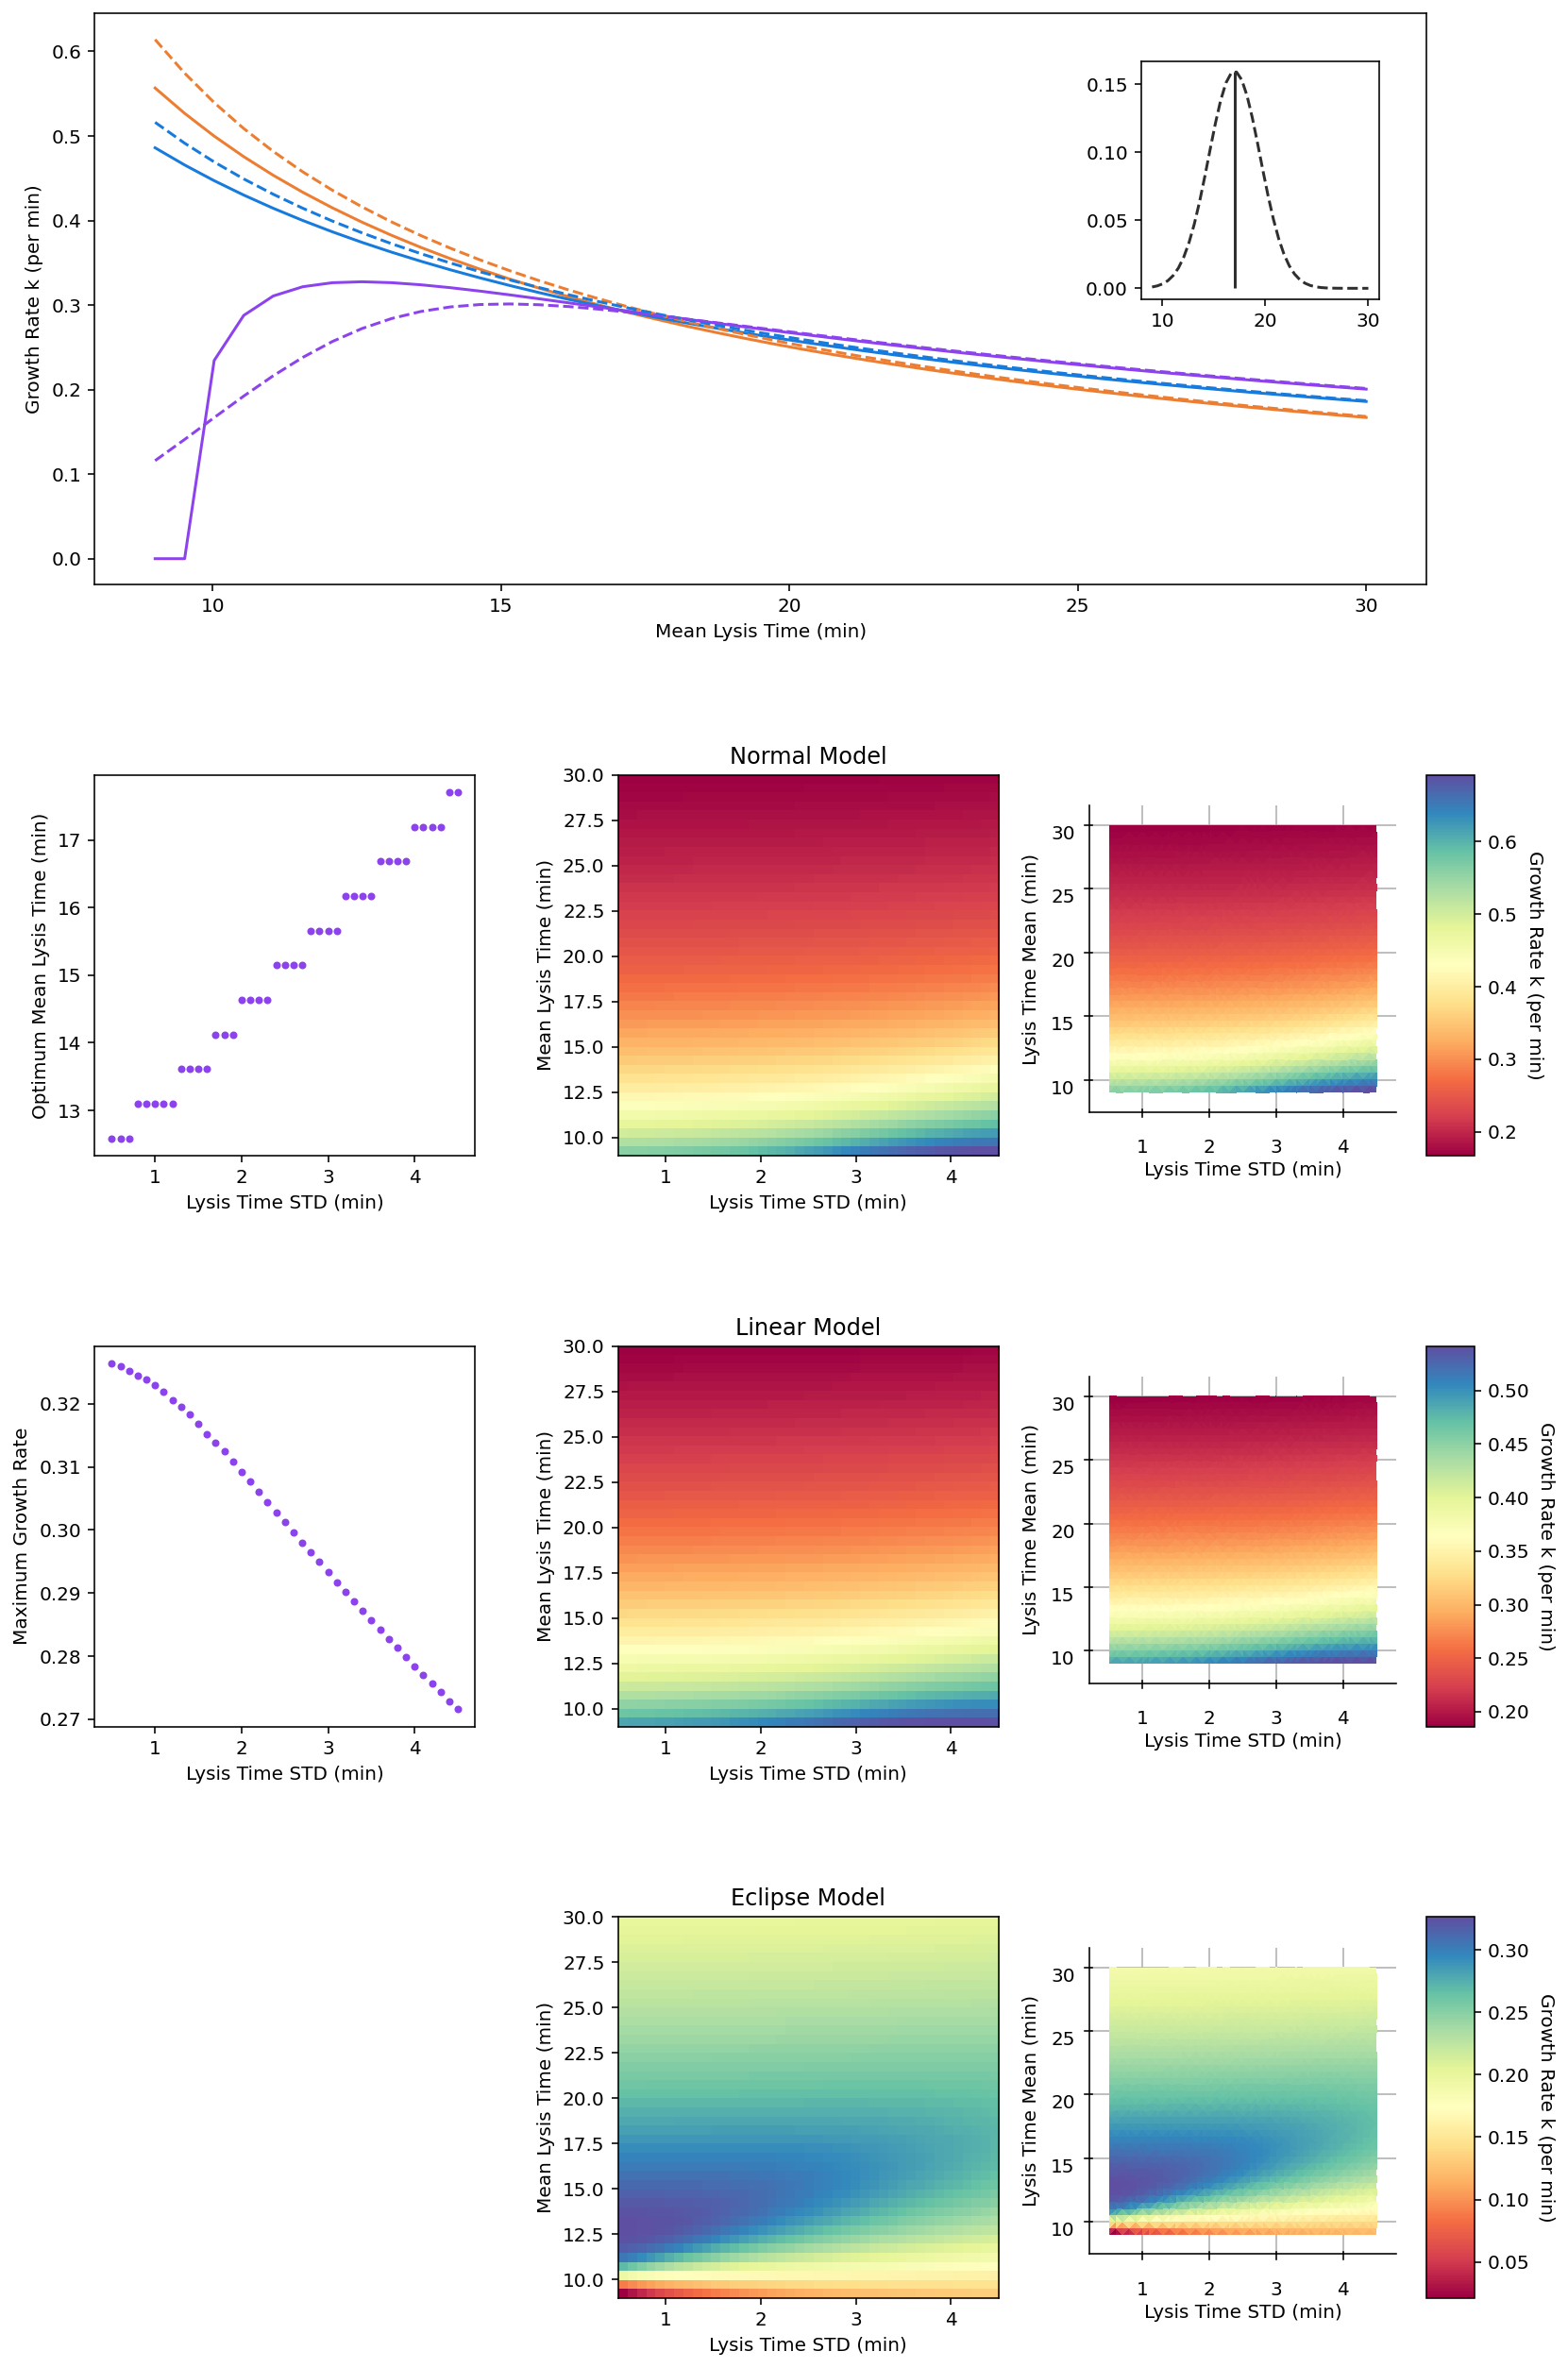

<Figure size 640x480 with 0 Axes>

In [18]:
if axis_1 is means or axis_1 is scales:

    ## Initialise Figure ##
    X, Y = 16, 27
    scaling = 0.7
    fig = plt.figure(figsize=(X*scaling,Y*scaling), dpi = 144)
    
    ax_0 = fig.add_axes([0.5/X, 21/Y, 14/X, 6/Y])    # large top box - k curves
    ax_1 = fig.add_axes([0.5/X, 15/Y, 4/X, 4/Y])     # left top box - optimum lysis time
    ax_2 = fig.add_axes([0.5/X, 9/Y, 4/X, 4/Y])     # left bottom box - growth rate at optimum lysis time
    ax_6 = fig.add_axes([11.5/X, 24/Y, 2.5/X, 2.5/Y])    # inset box - "noisy" distribution
    
    ax_7 = fig.add_axes([10/X, 14.5/Y, 5/X, 5/Y], projection = "3d")    # right top box - normal heatmap
    ax_8 = fig.add_axes([10/X, 8.5/Y, 5/X, 5/Y], projection = "3d")     # right middle box - linear heatmap
    ax_9 = fig.add_axes([10/X, 2.5/Y, 5/X, 5/Y], projection = "3d")     # right bottom box - eclipse heatmap
    
    ax_3 = fig.add_axes([6/X, 15/Y, 4/X, 4/Y])     # right top box - normal heatmap
    ax_4 = fig.add_axes([6/X, 9/Y, 4/X, 4/Y])     # right middle box - linear heatmap
    ax_5 = fig.add_axes([6/X, 3/Y, 4/X, 4/Y])     # right bottom box - eclipse heatmap
    cax_3 = fig.add_axes([14.5/X, 15/Y, 0.5/X, 4/Y])
    cax_4 = fig.add_axes([14.5/X, 9/Y, 0.5/X, 4/Y])
    cax_5 = fig.add_axes([14.5/X, 3/Y, 0.5/X, 4/Y])
    
    
    
    ## Plot Heatmaps ##
    im_3 = ax_3.imshow(ks[:,:,0], cmap = spectral, origin = "lower", interpolation = "none",
                       aspect = (max(axis_2)-min(axis_2))/(max(axis_1)-min(axis_1)), # force square
                       norm = "linear", extent = [min(axis_2), max(axis_2), min(axis_1), max(axis_1)])
    ax_3.set_xlabel(label_2)
    ax_3.set_ylabel(label_1)
    ax_3.set_title("Normal Model")
    cbar_3 = fig.colorbar(im_3, cax = cax_3)
    cbar_3.outline.set_visible(True)
    cbar_3.ax.set_ylabel("Growth Rate k (per min)", rotation=-90, va="bottom")
    
    im_4 = ax_4.imshow(ks[:,:,1], cmap = spectral, origin = "lower", interpolation = "none",
                       aspect = (max(axis_2)-min(axis_2))/(max(axis_1)-min(axis_1)), # force square
                       norm = "linear", extent = [min(axis_2), max(axis_2), min(axis_1), max(axis_1)])
    ax_4.set_xlabel(label_2)
    ax_4.set_ylabel(label_1)
    ax_4.set_title("Linear Model")
    cbar_4 = fig.colorbar(im_4, cax = cax_4)
    cbar_4.outline.set_visible(True)
    cbar_4.ax.set_ylabel("Growth Rate k (per min)", rotation=-90, va="bottom")
    
    im_5 = ax_5.imshow(ks[:,:,2], cmap = spectral, origin = "lower", interpolation = "none",
                       aspect = (max(axis_2)-min(axis_2))/(max(axis_1)-min(axis_1)), # force square
                       norm = "linear", extent = [min(axis_2), max(axis_2), min(axis_1), max(axis_1)])
    ax_5.set_xlabel(label_2)
    ax_5.set_ylabel(label_1)
    ax_5.set_title("Eclipse Model")
    cbar_5 = fig.colorbar(im_5, cax = cax_5)
    cbar_5.outline.set_visible(True)
    cbar_5.ax.set_ylabel("Growth Rate k (per min)", rotation=-90, va="bottom")
    
    
    
    ## Plot Triangulated Surfaces ##
    X = true_stds[:,:,0].flatten()
    if axis_2 is alphas:
        X = true_skews[:,:,0].flatten()
    Y = true_means[:,:,0].flatten()
    Z = ks[:,:,0].flatten()
    ax_7.plot_trisurf(X, Y, Z, cmap = spectral, edgecolor = "none", linewidth = 0, antialiased = False)
    ax_7.view_init(elev = 90, azim = -90)
    ax_7.set_proj_type('ortho')
    ax_7.set_ylabel("Lysis Time Mean (min)")
    ax_7.set_xlabel("Lysis Time STD (min)")
    if axis_2 is alphas:
        ax_7.set_xlabel("Lysis Time Skew (min)")
    ax_7.set_zticks([])
    ax_7.xaxis.set_pane_color(transparent)
    ax_7.yaxis.set_pane_color(transparent)
    ax_7.zaxis.set_pane_color(transparent)
    
    X = true_stds[:,:,0].flatten()
    if axis_2 is alphas:
        X = true_skews[:,:,0].flatten()
    Y = true_means[:,:,0].flatten()
    Z = ks[:,:,1].flatten()
    ax_8.plot_trisurf(X, Y, Z, cmap = spectral, edgecolor = "none", linewidth = 0, antialiased = False)
    ax_8.view_init(elev = 90, azim = -90)
    ax_8.set_proj_type('ortho')
    ax_8.set_ylabel("Lysis Time Mean (min)")
    ax_8.set_xlabel("Lysis Time STD (min)")
    if axis_2 is alphas:
        ax_8.set_xlabel("Lysis Time Skew (min)")
    ax_8.set_zticks([])
    ax_8.xaxis.set_pane_color(transparent)
    ax_8.yaxis.set_pane_color(transparent)
    ax_8.zaxis.set_pane_color(transparent)
    
    X = true_stds[:,:,0].flatten()
    if axis_2 is alphas:
        X = true_skews[:,:,0].flatten()
    Y = true_means[:,:,0].flatten()
    Z = ks[:,:,2].flatten()
    ax_9.plot_trisurf(X, Y, Z, cmap = spectral, edgecolor = "none", linewidth = 0, antialiased = False)
    ax_9.view_init(elev = 90, azim = -90)
    ax_9.set_proj_type('ortho')
    ax_9.set_ylabel("Lysis Time Mean (min)")
    ax_9.set_xlabel("Lysis Time STD (min)")
    if axis_2 is alphas:
        ax_9.set_xlabel("Lysis Time Skew (min)")
    ax_9.set_zticks([])
    ax_9.xaxis.set_pane_color(transparent)
    ax_9.yaxis.set_pane_color(transparent)
    ax_9.zaxis.set_pane_color(transparent)
    
    
    
    
    
    ## Plot k Curves - Atomic Clock Phages ##
    # k = ln(beta)/tau
    ax_0.plot(axis_1, robust_log(150)/axis_1, color = orange)  # Normal
    ax_0.plot(axis_1, robust_log_array(axis_1 * 8.82)/axis_1, color = blue)  # Linear
    ax_0.plot(axis_1, robust_log_array((axis_1 - 9.5) * 20)/axis_1, color = purple)  # Eclipse
    ax_0.set_xlabel(label_1)
    ax_0.set_ylabel("Growth Rate k (per min)")
    
        
    ## Plot other k Curves ##
    idxs_to_show = []
    
    if axis_2 is stds:
        mean_to_show = 17
        std_to_show = 2.5
        idxs_to_show += [list(stds).index(std_to_show)]
    elif axis_2 is shapes_E:
        mean_to_show = 17
        shapes_to_show = [2, 50]
        for s in shapes_to_show:
            idxs_to_show += [list(shapes_E).index(s)]
    elif axis_2 is shapes_W:
        mean_to_show = 17
        shapes_to_show = [2, 10]
        for s in shapes_to_show:
            idxs_to_show += [list(shapes_W).index(s)]
    elif axis_2 is alphas:
        mean_to_show = 17
        alphas_to_show = [-10, 10, 0]
        for a in alphas_to_show:
            idxs_to_show += [list(alphas).index(a)]
    else:
        oops
    
    ax_0.plot(axis_1, ks[:,idxs_to_show[0],0], color = orange, linestyle = "dashed")  # Normal
    ax_0.plot(axis_1, ks[:,idxs_to_show[0],1], color = blue, linestyle = "dashed")  # Linear
    ax_0.plot(axis_1, ks[:,idxs_to_show[0],2], color = purple, linestyle = "dashed")  # Eclipse
    
    if len(idxs_to_show) > 1:
        ax_0.plot(axis_1, ks[:,idxs_to_show[1],0], color = orange, linestyle = "dotted")  # Normal
        ax_0.plot(axis_1, ks[:,idxs_to_show[1],1], color = blue, linestyle = "dotted")  # Linear
        ax_0.plot(axis_1, ks[:,idxs_to_show[1],2], color = purple, linestyle = "dotted")  # Eclipse
    if len(idxs_to_show) > 2:
        ax_0.plot(axis_1, ks[:,idxs_to_show[2],0], color = orange, linestyle = "solid", alpha = 0.6)  # Normal
        ax_0.plot(axis_1, ks[:,idxs_to_show[2],1], color = blue, linestyle = "solid", alpha = 0.6)  # Linear
        ax_0.plot(axis_1, ks[:,idxs_to_show[2],2], color = purple, linestyle = "solid", alpha = 0.6)  # Eclipse
        
    ## Plot Inset ##
    if axis_2 is stds:
        ax_6.plot(axis_1, distribution(axis_1, mean_to_show, std_to_show), color = charcoal, linestyle = "dashed")
        ax_6.vlines(mean_to_show, ymin = min(distribution(axis_1, mean_to_show, std_to_show)), ymax = max(distribution(axis_1, mean_to_show, std_to_show)), color = charcoal, linestyle = "solid")
    elif axis_2 is shapes_E or axis_2 is shapes_W:
        ax_6.plot(axis_1, distribution(axis_1, mean_to_show, shapes_to_show[0]), color = charcoal, linestyle = "dashed")
        ax_6.plot(axis_1, distribution(axis_1, mean_to_show, shapes_to_show[1]), color = charcoal, linestyle = "dotted")
        ax_6.vlines(mean_to_show, ymin = min(distribution(axis_1, mean_to_show, shapes_to_show[1])), ymax = max(distribution(axis_1, mean_to_show, shapes_to_show[1])), color = charcoal, linestyle = "solid")
    elif axis_2 is alphas:
        ax_6.plot(axis_1, distribution(axis_1, mean_to_show, std, alphas_to_show[0]), color = charcoal, linestyle = "dashed")
        ax_6.plot(axis_1, distribution(axis_1, mean_to_show, std, alphas_to_show[1]), color = charcoal, linestyle = "dotted")
        ax_6.plot(axis_1, distribution(axis_1, mean_to_show, std, alphas_to_show[2]), color = charcoal, linestyle = "solid", alpha = 0.6)
        ax_6.vlines(mean_to_show, ymin = min(distribution(axis_1, mean_to_show, std, alphas_to_show[0])), ymax = max(distribution(axis_1, mean_to_show, std, alphas_to_show[0])), color = charcoal, linestyle = "solid")
    else:
        oops
    
    
    
    
    ## Plot optima ##
    
    for j, val2 in enumerate(axis_2):
        k_max = max(ks[:,j,2])
        i_max = ks[:,j,2].argmax(axis=0)
        ax_1.plot(axis_2[j], axis_1[i_max], color = purple, linestyle = "none", marker = ".")
        ax_2.plot(axis_2[j], k_max, color = purple, linestyle = "none", marker = ".")
    
    # ax_1.set_ylim(min(eva1), max(eva1))
    ax_1.set_xlabel(label_2)
    ax_1.set_ylabel("Optimum {}".format(label_1))
    
    ax_2.set_xlabel(label_2)
    ax_2.set_ylabel("Maximum Growth Rate")
    
    
    
    
    ## Save ##
    plt.savefig("NewBiggerFigure {} {} {}".format(distribution.__name__, label_1, label_2), bbox_inches = "tight")
    plt.show()
    plt.clf()

## Compare STD vs Skew

In [19]:
if axis_1 is stds and axis_2 is alphas:

    ## Initialise Figure ##
    X, Y = 16, 27
    scaling = 0.7
    fig = plt.figure(figsize=(X*scaling,Y*scaling), dpi = 144)
    
    ax_1 = fig.add_axes([0.5/X, 15/Y, 4/X, 4/Y])     # left top box - optimum lysis time
    ax_2 = fig.add_axes([0.5/X, 9/Y, 4/X, 4/Y])     # left bottom box - growth rate at optimum lysis time
    
    ax_7 = fig.add_axes([10/X, 14.5/Y, 5/X, 5/Y], projection = "3d")    # right top box - normal heatmap
    ax_8 = fig.add_axes([10/X, 8.5/Y, 5/X, 5/Y], projection = "3d")     # right middle box - linear heatmap
    ax_9 = fig.add_axes([10/X, 2.5/Y, 5/X, 5/Y], projection = "3d")     # right bottom box - eclipse heatmap
    
    ax_3 = fig.add_axes([6/X, 15/Y, 4/X, 4/Y])     # right top box - normal heatmap
    ax_4 = fig.add_axes([6/X, 9/Y, 4/X, 4/Y])     # right middle box - linear heatmap
    ax_5 = fig.add_axes([6/X, 3/Y, 4/X, 4/Y])     # right bottom box - eclipse heatmap
    cax_3 = fig.add_axes([14.5/X, 15/Y, 0.5/X, 4/Y])
    cax_4 = fig.add_axes([14.5/X, 9/Y, 0.5/X, 4/Y])
    cax_5 = fig.add_axes([14.5/X, 3/Y, 0.5/X, 4/Y])
    
    
    
    ## Plot Heatmaps ##
    im_3 = ax_3.imshow(ks[:,:,0], cmap = spectral, origin = "lower", interpolation = "none",
                       aspect = (max(axis_2)-min(axis_2))/(max(axis_1)-min(axis_1)), # force square
                       norm = "linear", extent = [min(axis_2), max(axis_2), min(axis_1), max(axis_1)])
    ax_3.set_xlabel(label_2)
    ax_3.set_ylabel(label_1)
    ax_3.set_title("Normal Model")
    cbar_3 = fig.colorbar(im_3, cax = cax_3)
    cbar_3.outline.set_visible(True)
    cbar_3.ax.set_ylabel("Growth Rate k (per min)", rotation=-90, va="bottom")
    
    im_4 = ax_4.imshow(ks[:,:,1], cmap = spectral, origin = "lower", interpolation = "none",
                       aspect = (max(axis_2)-min(axis_2))/(max(axis_1)-min(axis_1)), # force square
                       norm = "linear", extent = [min(axis_2), max(axis_2), min(axis_1), max(axis_1)])
    ax_4.set_xlabel(label_2)
    ax_4.set_ylabel(label_1)
    ax_4.set_title("Linear Model")
    cbar_4 = fig.colorbar(im_4, cax = cax_4)
    cbar_4.outline.set_visible(True)
    cbar_4.ax.set_ylabel("Growth Rate k (per min)", rotation=-90, va="bottom")
    
    im_5 = ax_5.imshow(ks[:,:,2], cmap = spectral, origin = "lower", interpolation = "none",
                       aspect = (max(axis_2)-min(axis_2))/(max(axis_1)-min(axis_1)), # force square
                       norm = "linear", extent = [min(axis_2), max(axis_2), min(axis_1), max(axis_1)])
    ax_5.set_xlabel(label_2)
    ax_5.set_ylabel(label_1)
    ax_5.set_title("Eclipse Model")
    cbar_5 = fig.colorbar(im_5, cax = cax_5)
    cbar_5.outline.set_visible(True)
    cbar_5.ax.set_ylabel("Growth Rate k (per min)", rotation=-90, va="bottom")
    
    
    
    ## Plot Triangulated Surfaces ##
    X = true_skews[:,:,0].flatten()
    Y = true_stds[:,:,0].flatten()
    Z = ks[:,:,0].flatten()
    ax_7.plot_trisurf(X, Y, Z, cmap = spectral, edgecolor = "none", linewidth = 0, antialiased = False)
    ax_7.view_init(elev = 90, azim = -90)
    ax_7.set_proj_type('ortho')
    ax_7.set_ylabel("Lysis Time STD (min)")
    ax_7.set_xlabel("Lysis Time Skew (min)")
    ax_7.set_zticks([])
    ax_7.xaxis.set_pane_color(transparent)
    ax_7.yaxis.set_pane_color(transparent)
    ax_7.zaxis.set_pane_color(transparent)
    
    X = true_skews[:,:,0].flatten()
    Y = true_stds[:,:,0].flatten()
    Z = ks[:,:,1].flatten()
    ax_8.plot_trisurf(X, Y, Z, cmap = spectral, edgecolor = "none", linewidth = 0, antialiased = False)
    ax_8.view_init(elev = 90, azim = -90)
    ax_8.set_proj_type('ortho')
    ax_8.set_ylabel("Lysis Time STD (min)")
    ax_8.set_xlabel("Lysis Time Skew (min)")
    ax_8.set_zticks([])
    ax_8.xaxis.set_pane_color(transparent)
    ax_8.yaxis.set_pane_color(transparent)
    ax_8.zaxis.set_pane_color(transparent)
    
    X = true_skews[:,:,0].flatten()
    Y = true_stds[:,:,0].flatten()
    Z = ks[:,:,2].flatten()
    ax_9.plot_trisurf(X, Y, Z, cmap = spectral, edgecolor = "none", linewidth = 0, antialiased = False)
    ax_9.view_init(elev = 90, azim = -90)
    ax_9.set_proj_type('ortho')
    ax_9.set_ylabel("Lysis Time STD (min)")
    ax_9.set_xlabel("Lysis Time Skew (min)")
    ax_9.set_zticks([])
    ax_9.xaxis.set_pane_color(transparent)
    ax_9.yaxis.set_pane_color(transparent)
    ax_9.zaxis.set_pane_color(transparent)
    
    
    
    
    ## Plot optima ##
    for j, val2 in enumerate(axis_2):
        k_max = max(ks[:,j,2])
        i_max = ks[:,j,2].argmax(axis=0)
        ax_1.plot(axis_2[j], axis_1[i_max], color = purple, linestyle = "none", marker = ".")
        ax_2.plot(axis_2[j], k_max, color = purple, linestyle = "none", marker = ".")
    
    # ax_1.set_ylim(min(eva1), max(eva1))
    ax_1.set_xlabel(label_2)
    ax_1.set_ylabel("Optimum {}".format(label_1))
    
    ax_2.set_xlabel(label_2)
    ax_2.set_ylabel("Maximum Growth Rate")
    
    
    
    
    ## Save ##
    plt.savefig("NewSkewFigure {} {} {}".format(distribution.__name__, label_1, label_2), bbox_inches = "tight")
    plt.show()
    plt.clf()